# Smoothed-gridded seismicity of the Indian Subcontinent

The purpose of this notebook is to reproduce the smoothed-gridded seismicity models of Nath & Thingbaijam (2012) since their electronic supplement does state the units.

The agreement obtained is reasonably good, though rates obtained are typically 10-50% lower than those published. Still this is acceptable, since the main objective was to confirm that the units in the electronic supplement were annual rates. It is not clear what causes the remaining discrepancies. Some possibilities are: declustering, assignment of events to layers, undocumented details of the smoothing kernel used.

This script can be used to implement several improvements in the smoothed-gridded seismicity model. The improved model would be:
1. Derived from a re-declustered catalog (`catalog2` or `catalog3` below), 
1. Based on improved estimates of completeness as a function of time (`completeness_df` rather than `old_completeness_df`, and 
1. Implemented as a single smoothed-gridded seismicity model with time-varying completeness `completeness_tables`, rather than two such models which assume fixed completeness `start_min`.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from time import time
from copy import deepcopy
from IPython.display import display
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

from openquake.hazardlib import geo
from openquake.hmtk.plotting.seismicity.catalogue_plots \
    import plot_depth_histogram

from openquake.hmtk.parsers.catalogue import CsvCatalogueParser
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity \
    import SmoothedSeismicity
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian \
    import IsotropicGaussian
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from openquake.hmtk.plotting.seismicity.completeness import plot_stepp_1972

from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff \
    import GardnerKnopoffType1 
from openquake.hmtk.seismicity.declusterer.distance_time_windows \
    import UhrhammerWindow

In [3]:
import poisson_test

import sys
sys.path.append('../utilities')
from toolbox import stdval, annotate, great_circle_distance_m, df_diff
from source_model_tools import (
    plot_mag_time_density_slices, plot_completeness_slices, 
    plot_depth_distance, plot_smoothed, plot_smoothed_maps, 
    COORDINATE_ALIASES, COORDINATES)

In [4]:
# define some lists needed at different stages

LAYERS_DF = pd.read_csv('../Source Models/layers.csv', index_col='layerid')
LAYERS_DF.zmid = (LAYERS_DF.zmin + LAYERS_DF.zmax)/2
display(LAYERS_DF)

min_mags = [4.5, 5.5]
corr_dists_km = [65, 85]

df_models = pd.DataFrame(list(zip(min_mags, corr_dists_km)), 
                         columns=['min mag','corr dist'])
display(df_models)

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


,zmin,zmax
layerid,,
1,0.0,25.0
2,25.0,70.0
3,70.0,180.0
4,180.0,300.0


,min mag,corr dist
0,4.5,65
1,5.5,85


In [5]:
# define some input and output filenames
catalogue_txt = '../Catalogue/SACAT1900_2008v2.txt'
catalogue_csv = catalogue_txt.replace('.txt','.csv')
old_completeness_csv = '../Data/thingbaijam2011seismogenic/Table1.csv'
new_completeness_csv = 'Completeness.csv'

model_path = '../Data/nath2012probabilistic'
old_txt_template = os.path.join(model_path,'lay%dsmooth%g.txt')
recomputed_path = './Recomputed'
large_csv_template = os.path.join(recomputed_path, 'smoothed_seismicity_layer%d_mmin%g.csv')
small_csv_template = os.path.join(recomputed_path, 'smoothed_source_model_mmin_%g_layer_%d.csv')
new_txt_template = os.path.join(recomputed_path, os.path.split(old_txt_template)[1])

In [6]:
# read and reformat old completeness tables
old_completeness_df = pd.read_csv(old_completeness_csv, header=[0,1], index_col=[0,1])
old_completeness_df.index.set_levels(
    [[float(item) for item in items] for items in old_completeness_df.index.levels],
    inplace=True)
old_completeness_df.columns.set_levels(
    [float(item) for item in old_completeness_df.columns.get_level_values('mmin').unique()],
    level='mmin', inplace=True)

old_completeness_df.to_latex(old_completeness_csv.replace('.csv', '.tex'))
old_completeness_tables = [[[old_completeness_df.at[(z_min, z_max), (mag, 'start')], float(mag)]
                        for mag in row.index.get_level_values('mmin').unique()] 
                       for (z_min, z_max), row in old_completeness_df.iterrows()]
old_completeness_tables = np.array(old_completeness_tables)
display(old_completeness_df)

mmin          4.0         4.5         5.5      
year        start   end start   end start   end
zmin  zmax                                     
0.0   25.0   1994  2008  1964  2008  1903  2008
25.0  70.0   1990  2008  1964  2008  1902  2008
70.0  180.0  1996  2008  1964  2008  1914  2008
180.0 300.0  1984  2008  1970  2008  1912  2008

In [7]:
# read and reformat new completeness tables 
# these tables are improved, based on Stepp/magnitude-time plots
completeness_df = pd.read_csv(new_completeness_csv, header=[0,1], index_col=[0,1], 
                              dtype={'zmin': float, 'zmax': float})
completeness_df.index.set_levels(
    [[float(item) for item in items] for items in completeness_df.index.levels],
    inplace=True)
completeness_df.columns.set_levels(
    [float(item) for item in completeness_df.columns.get_level_values('mmin').unique()],
    level='mmin', inplace=True)

completeness_df.to_latex(new_completeness_csv.replace('.csv', '.tex'))
completeness_tables = [[[completeness_df.at[(z_min, z_max), (mag, 'start')], float(mag)]
                        for mag in row.index.get_level_values(0).unique()] 
                       for (z_min, z_max), row in completeness_df.iterrows()]
completeness_tables = np.array(completeness_tables)
display(completeness_df)

mmin          4.0         4.5         5.0         5.5         6.0         6.5  \
year        start   end start   end start   end start   end start   end start   
zmin  zmax                                                                      
0.0   25.0   2004  2008  1995  2008  1976  2008  1962  2008  1962  2008  1905   
25.0  70.0   2004  2008  1995  2008  1976  2008  1962  2008  1962  2008  1905   
70.0  180.0  1995  2008  1976  2008  1965  2008  1965  2008  1965  2008  1905   
180.0 300.0  1981  2008  1965  2008  1965  2008  1965  2008  1965  2008  1905   

mmin               
year          end  
zmin  zmax         
0.0   25.0   2008  
25.0  70.0   2008  
70.0  180.0  2008  
180.0 300.0  2008

In [8]:
# reformat the catalogue and write it to CSV
catalogue_reformat_df = pd.read_csv(catalogue_txt, sep='\t')
catalogue_reformat_df.columns = [item.lower() for item in catalogue_reformat_df.columns]
catalogue_reformat_df['eventID'] = catalogue_reformat_df.index.values
RENAME_COLS = {
    'source': 'Agency',
    'lat': 'latitude',
    'lon': 'longitude',
    'hh': 'hour',
    'mm': 'minute',
    'ss': 'second',
    'mag_mw': 'magnitude',
    'mag_mw_err': 'sigmaMagnitude',
    'depth_err': 'depthError',
    'shock_type': 'comment',
}
catalogue_reformat_df.rename(columns=RENAME_COLS, inplace=True)
catalogue_reformat_df.to_csv(catalogue_csv, index=False)

In [9]:
# parse the CSV catalogue
parser = CsvCatalogueParser(catalogue_csv) 
catalogue = parser.read_file() 

print('Number of entries:', len(catalogue.data['eventID']))
print('Keys before cleaning:', ', '.join(catalogue.data.keys()))

coordinate_limits = catalogue.get_bounding_box()
min_lon, max_lon, min_lat, max_lat = coordinate_limits
print('Longitudes: %g to %g' % (min_lon, max_lon))
print('Latitudes: %g to %g' % (min_lat, max_lat))

catalogue.sort_catalogue_chronologically()

Catalogue Attribute mag_err is not a recognised catalogue key
Catalogue Attribute nmag_type is not a recognised catalogue key
Catalogue Attribute mag is not a recognised catalogue key
Number of entries: 50332
Keys before cleaning: SemiMajor90, second, sigmaMagnitude, SemiMinor90, longitude, eventID, latitude, year, magnitude, minute, depthError, depth, ErrorStrike, magnitudeType, month, day, hour, timeError, comment, flag, Agency
Longitudes: 55 to 101
Latitudes: 2 to 40


In [10]:
# clean out empty keys allowing easy conversion to dataframe (for ease of display and query)
catalogue.data = {key: value for key, value in catalogue.data.items() if len(value)}
        
# it will be helpful to order the more interesting columns
useful_keys = ['eventID','Agency','comment','layerid',
               'magnitude','sigmaMagnitude',
               'year','month','day','hour','minute','second',
               'longitude','latitude','depth','depthError']

In [11]:
# assign layer ids and study contentious assignments
layer_id_array = np.full_like(catalogue.data['depth'], np.nan)
for layer_id, layer in LAYERS_DF.iterrows():
    at_depth = ((catalogue.data['depth'] >= layer['zmin']) & 
                (catalogue.data['depth'] < layer['zmax']))
    layer_id_array[at_depth] = layer_id

too_deep = catalogue.data['depth'] > LAYERS_DF.zmax.max()
too_deep_layer = 4
layer_id_array[too_deep] = too_deep_layer
print('Assigning %d/%d events below %g km depth to layer %d' % 
      (sum(too_deep), len(too_deep), LAYERS_DF.zmax.max(), too_deep_layer))

unassigned = catalogue.data['depth'] == -1
all_df = gpd.GeoDataFrame(catalogue.data)
all_df.geometry = [Point(longitude, latitude) 
                   for longitude, latitude in zip(all_df['longitude'], all_df['latitude'])]
all_df['layerid'] = layer_id_array

unasssigned_df = all_df.loc[unassigned]
assigned_df = all_df.loc[~unassigned]

Assigning 46/50332 events below 300 km depth to layer 4


In [12]:
distance_m = great_circle_distance_m(
    unasssigned_df['latitude'].values.reshape((-1, 1)),
    unasssigned_df['longitude'].values.reshape((-1, 1)),
    assigned_df['latitude'].values.reshape((1, -1)),
    assigned_df['longitude'].values.reshape((1, -1)))

In [13]:
assigned_df.index[np.argmin(distance_m, axis=1)]

Int64Index([28529, 22479, 17068, 28937, 21493,  8124, 30565, 19367, 24244,
              192,
            ...
            23960, 21512, 45770, 30609, 20830, 44932, 22682,  1829,  5752,
            24172],
           dtype='int64', length=879)

In [14]:
unasssigned_df['layerid'] = assigned_df.loc[assigned_df.index[np.argmin(distance_m, axis=1)], 'layerid'].values

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
print('Counts of events reassigned to layers:\n' + str(unasssigned_df['layerid'].value_counts()))

Counts of events reassigned to layers:
1.0    471
2.0    344
3.0     47
4.0     17
Name: layerid, dtype: int64


In [16]:
all_df = pd.concat((assigned_df, unasssigned_df)).sort_index().drop(columns='geometry')

In [17]:
all_df.head()

,Agency,comment,day,depth,depthError,eventID,hour,latitude,longitude,magnitude,minute,month,second,sigmaMagnitude,year,layerid
0,JS2004a,Mainshock,16,-1.0,-1.0,0,-1,20.4,73.0,3.2,-1,1,-1.0,0.46,1900,2.0
1,ASC2009a,Mainshock,7,70.0,-1.0,1,-1,10.8,76.8,5.7,-1,2,-1.0,0.30,1900,3.0
2,JS2004a,Mainshock,27,-1.0,-1.0,2,-1,12.0,75.0,4.6,-1,4,-1.0,0.46,1901,2.0
3,AM2000a,Mainshock,17,-1.0,-1.0,3,5,31.0,68.4,6.2,57,10,-1.0,-1.00,1901,1.0
4,AM2000a,Mainshock,18,-1.0,-1.0,4,4,32.0,77.0,6.3,-1,11,-1.0,-1.00,1901,1.0


In [18]:
catalogue.data = {key: all_df[key].values for key in all_df.columns}

In [19]:
#purge events which are too small to be of interest
mag_negligible = 4.
too_small = catalogue.data['magnitude'] <= mag_negligible
catalogue.purge_catalogue(~too_small)
print('Purged %d/%d events below M=%g' % (sum(too_small), len(too_small), mag_negligible))

Purged 17483/50332 events below M=4


In [20]:
for key in catalogue.data.keys():
    print(key, type(catalogue.data[key]), np.array(catalogue.data[key]).shape)

second <class 'numpy.ndarray'> (32849,)
eventID <class 'numpy.ndarray'> (32849,)
sigmaMagnitude <class 'numpy.ndarray'> (32849,)
longitude <class 'numpy.ndarray'> (32849,)
magnitude <class 'numpy.ndarray'> (32849,)
layerid <class 'numpy.ndarray'> (32849,)
latitude <class 'numpy.ndarray'> (32849,)
minute <class 'numpy.ndarray'> (32849,)
depth <class 'numpy.ndarray'> (32849,)
year <class 'numpy.ndarray'> (32849,)
month <class 'numpy.ndarray'> (32849,)
day <class 'numpy.ndarray'> (32849,)
hour <class 'numpy.ndarray'> (32849,)
Agency <class 'numpy.ndarray'> (32849,)
comment <class 'numpy.ndarray'> (32849,)
depthError <class 'numpy.ndarray'> (32849,)


In [21]:
sort_mag = ['magnitude','year','month','day','hour','minute','second']
reverse_mag = [False, True, True, True, True, True, True]

print('Bottom 5 events:')
display(pd.DataFrame(catalogue.data)[useful_keys].sort_values(sort_mag).head(5))
print('Top 15 events:')
display(pd.DataFrame(catalogue.data)[useful_keys].sort_values(sort_mag, ascending=reverse_mag).head(15))

Bottom 5 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
13,14,JS2004a,Mainshock,2.0,4.1,0.46,1903,5,17,-1,-1,-1.0,80.0,23.0,-1.0,-1.0
26,29,JS2004a,Mainshock,1.0,4.1,0.46,1905,4,2,-1,-1,-1.0,80.1,16.0,-1.0,-1.0
129,139,JS2004a,Mainshock,1.0,4.1,0.46,1922,3,13,-1,-1,-1.0,71.0,22.0,-1.0,-1.0
173,186,JS2004a,Mainshock,2.0,4.1,0.46,1927,1,1,-1,-1,-1.0,83.4,17.7,-1.0,-1.0
470,510,JS2004a,Mainshock,1.0,4.1,0.46,1941,5,28,-1,-1,-1.0,73.1,18.1,-1.0,-1.0


Top 15 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
21993,32897,EHB,Mainshock,1.0,9.1,0.10,2004,12,26,0,58,52.28,95.864,3.277,21.5,0.0
21994,32898,GCMT,Mainshock,2.0,9.1,0.10,2004,12,26,1,1,9.00,94.260,3.090,28.6,-1.0
562,618,T2008a,Mainshock,2.0,8.6,0.20,1950,8,15,14,9,30.00,96.500,28.500,45.0,-1.0
25728,37422,ISC,Aftershock,2.0,8.6,0.10,2005,3,28,16,9,37.11,97.064,2.058,33.7,0.0
324,345,SG1980a,Mainshock,2.0,8.1,0.20,1934,1,15,8,43,-1.00,87.090,27.550,25.0,-1.0
506,551,ISC;B1992a,Mainshock,2.0,8.1,0.20,1945,11,27,21,56,50.00,63.480,25.150,25.0,-1.0
75,83,ISC,Mainshock,2.0,8.0,0.23,1912,5,23,2,24,6.00,97.000,21.000,35.0,-1.0
27,30,W2005a,Mainshock,1.0,7.8,0.20,1905,4,4,-1,50,-1.00,76.300,32.300,-1.0,-1.0
1184,1331,USGS,Mainshock,4.0,7.8,0.10,1965,3,14,15,53,7.64,70.716,36.400,207.8,3.1
19124,26113,EHB,Mainshock,1.0,7.8,0.10,2001,11,14,9,26,12.65,90.571,35.876,15.0,0.0


At a glance, there are 2 mainshocks in the top 15 magnitude events which are actually duplicates (not even aftershocks, but detectable as aftershocks). This is problematic.

In [22]:
hours = [hour if hour != -1 else 0 for hour in catalogue.data['hour']]
minutes = [minute if minute != -1 else 0 for minute in catalogue.data['minute']]
seconds_float = [second if second != -1 else 0.0 for second in catalogue.data['second']]
seconds = [int(second_float) for second_float in seconds_float]
microseconds = ((np.array(seconds_float) - np.array(seconds))*1e6).astype(int).tolist()

date_components = zip(catalogue.data['year'], catalogue.data['month'], 
                      catalogue.data['day'], hours, minutes, seconds, microseconds)
catalogue.data['date'] = [datetime(year, month, day, hour, minute, second, microsecond) 
                          for year, month, day, hour, minute, second, microsecond in date_components]


In [23]:
report_cols = ['eventID', 'Agency', 'date', 'magnitude', 'layerid', 'depth']
pd.DataFrame(catalogue.data)[report_cols].sort_values(
    ['magnitude', 'date'], ascending=[False, True]).head(2).to_latex(
        'top2.tex', index=False)

In [24]:
catalogue_temp = deepcopy(catalogue)
catalogue_temp.purge_catalogue((catalogue_temp.data['depth'] > 0) & (catalogue_temp.data['magnitude'] > 5.5))

fig, ax = plt.subplots()
plot_depth_histogram(catalogue_temp, 5, normalisation=True, ax=ax)
ax.set_xlim(LAYERS_DF.zmin.min(), LAYERS_DF.zmax.max())
#plt.yscale('log')
#plt.ylim(1e-4, 1)
for depth in np.sort(np.unique(LAYERS_DF[['zmin', 'zmax']].values)):
    ax.axvline(depth, color='black', linestyle=':')
fig.savefig('Depth histogram (catalogue).png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [25]:
fig = plot_mag_time_density_slices(catalogue, old_completeness_tables, 'layerid', LAYERS_DF.index)
fig.savefig('Magnitude time density (catalogue, old completeness).png', dpi=300, bbox_inches='tight')
plt.close(fig)

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


In [26]:
fig = plot_mag_time_density_slices(catalogue, completeness_tables, 'layerid', LAYERS_DF.index)
fig.savefig('Magnitude time density (catalogue).png', dpi=300, bbox_inches='tight')
plt.close(fig)

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


In [27]:
# implement Nath & Thingbaijam's declustering first
declustered = deepcopy(catalogue)
is_mainshock = [item == 'Mainshock' for item in declustered.data['comment']]
declustered.purge_catalogue(is_mainshock)
print('Retained', declustered.get_number_events(), 'out of', catalogue.get_number_events(), 'events')

Retained 18763 out of 32849 events


In [28]:
print('Bottom 5 events:')
display(pd.DataFrame(declustered.data)[useful_keys].sort_values(sort_mag).head(5))
print('Top 10 events:')
display(pd.DataFrame(declustered.data)[useful_keys].sort_values(sort_mag, ascending=reverse_mag).head(10))

Bottom 5 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
13,14,JS2004a,Mainshock,2.0,4.1,0.46,1903,5,17,-1,-1,-1.0,80.0,23.0,-1.0,-1.0
25,29,JS2004a,Mainshock,1.0,4.1,0.46,1905,4,2,-1,-1,-1.0,80.1,16.0,-1.0,-1.0
118,139,JS2004a,Mainshock,1.0,4.1,0.46,1922,3,13,-1,-1,-1.0,71.0,22.0,-1.0,-1.0
160,186,JS2004a,Mainshock,2.0,4.1,0.46,1927,1,1,-1,-1,-1.0,83.4,17.7,-1.0,-1.0
416,510,JS2004a,Mainshock,1.0,4.1,0.46,1941,5,28,-1,-1,-1.0,73.1,18.1,-1.0,-1.0


Top 10 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
15843,32897,EHB,Mainshock,1.0,9.1,0.10,2004,12,26,0,58,52.28,95.864,3.277,21.5,0.0
15844,32898,GCMT,Mainshock,2.0,9.1,0.10,2004,12,26,1,1,9.00,94.260,3.090,28.6,-1.0
482,618,T2008a,Mainshock,2.0,8.6,0.20,1950,8,15,14,9,30.00,96.500,28.500,45.0,-1.0
286,345,SG1980a,Mainshock,2.0,8.1,0.20,1934,1,15,8,43,-1.00,87.090,27.550,25.0,-1.0
446,551,ISC;B1992a,Mainshock,2.0,8.1,0.20,1945,11,27,21,56,50.00,63.480,25.150,25.0,-1.0
68,83,ISC,Mainshock,2.0,8.0,0.23,1912,5,23,2,24,6.00,97.000,21.000,35.0,-1.0
26,30,W2005a,Mainshock,1.0,7.8,0.20,1905,4,4,-1,50,-1.00,76.300,32.300,-1.0,-1.0
1012,1331,USGS,Mainshock,4.0,7.8,0.10,1965,3,14,15,53,7.64,70.716,36.400,207.8,3.1
13875,26113,EHB,Mainshock,1.0,7.8,0.10,2001,11,14,9,26,12.65,90.571,35.876,15.0,0.0
13877,26115,GCMT,Mainshock,1.0,7.8,0.10,2001,11,14,9,43,12.27,92.405,35.602,15.0,-1.0


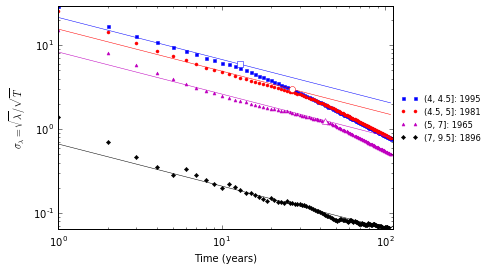

In [29]:
# fit completeness
comp_config = {'magnitude_bin': 0.5, 'time_bin': 1., 'increment_lock': True}
model = Stepp1971()
layer_declustered = declustered.data
model.completeness(declustered, comp_config)
model.simplify()

plot_stepp_1972.create_stepp_plot(model)
plt.savefig('Stepp completeness (raw, all layers).png', dpi=300, 
            bbox_inches='tight')

In [30]:
fig, completeness_tables = plot_completeness_slices(declustered, 'layerid', LAYERS_DF.index)
fig.savefig('Stepp completeness (mainshocks).png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [31]:
catalogue_temp = deepcopy(declustered)
catalogue_temp.purge_catalogue((catalogue_temp.data['depth'] > 0) & (catalogue_temp.data['magnitude'] > 5.5))

fig, ax = plt.subplots()
plot_depth_histogram(catalogue_temp, 5, normalisation=True, ax=ax)
ax.set_xlim(LAYERS_DF.zmin.min(), LAYERS_DF.zmax.max())
ax.axvline(LAYERS_DF.zmax.iloc[0], color='black', linestyle='--', linewidth=0.5, label='layer boundaries')
[ax.axvline(x, linewidth=0.5, color='black', linestyle='--') for x in LAYERS_DF.zmax.iloc[1:-1]]
ax.axvline(LAYERS_DF.zmid.iloc[0], color='black', linestyle='-.', linewidth=0.5, label='hypocentral depths')
[ax.axvline(x, linewidth=0.5, color='black', linestyle='-.') for x in LAYERS_DF.zmid.iloc[1:-1]]
ax.legend(fontsize='small')
fig.savefig('Depth histogram (mainshocks).png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [32]:
# select events in northeast and plot depth vs. northing
fig, axes = plt.subplots(2, 2, figsize=(6,6), sharey=True)
fig.subplots_adjust(wspace=0.1)
plot_depth_distance(catalogue_temp, (32, 40, 68, 87), 'latitude',
                    name='Hindu-Kush & Pamirs', ax=axes[0, 0])
axes[0, 0].set_ylabel('Depth (km)')
plot_depth_distance(catalogue_temp, (16, 34, 90, 98), 'latitude',
                    name='Indoburman Range', ax=axes[0, 1])
plot_depth_distance(catalogue_temp, (0, 16, 92, 100), 'longitude',
                    name='Andaman-Sumatra', ax=axes[1, 0])
axes[1, 0].set_ylabel('Depth (km)')
plot_depth_distance(catalogue_temp, (16, 34, 90, 98), 'longitude',
                    name='Indoburman Range', ax=axes[1, 1])
axes[1, 1].set_ylim(300, 0)
fig.savefig('Depth vs. distance (mainshocks).png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [33]:
# identify fore/aftershocks among the mainshocks
declust_config_gk = {'time_distance_window': UhrhammerWindow(), 
                     'fs_time_prop': 1.0}
declustering_gk = GardnerKnopoffType1()

declustered.data['cluster index'], declustered.data['cluster flag'] = declustering_gk.decluster(
    declustered, declust_config_gk)
print('Identified an additional %d foreshocks and %d aftershocks out of %d' % (
    sum(declustered.data['cluster flag'] == -1), 
    sum(declustered.data['cluster flag'] == 1), 
    len(declustered.data['cluster flag'])))

# implement declustering from mainshocks
declustered2 = deepcopy(declustered)
declustered2.purge_catalogue(declustered.data['cluster flag'] == 0)
print('Retained', declustered2.get_number_events(), 'out of', declustered.get_number_events(), 'events')

Identified an additional 1939 foreshocks and 1639 aftershocks out of 18763
Retained 15185 out of 18763 events


In [34]:
# identify fore/aftershocks in the raw catalogue
catalogue.data['cluster index'], catalogue.data['cluster flag'] = declustering_gk.decluster(
    catalogue, declust_config_gk)
print('Identified %d foreshocks and %d aftershocks out of %d events' % (
    sum(catalogue.data['cluster flag']  == -1), 
    sum(catalogue.data['cluster flag']  == 1), 
    len(catalogue.data['cluster flag'] )))

# implement declustering from raw catalogue
declustered3 = deepcopy(catalogue)
declustered3.purge_catalogue(catalogue.data['cluster flag'] == 0)
print('Retained', declustered3.get_number_events(), 'out of', catalogue.get_number_events(), 'events')

Identified 3584 foreshocks and 12481 aftershocks out of 32849 events
Retained 16784 out of 32849 events


In [35]:
df_diff23 = df_diff(declustered.data, declustered2.data, 'eventID')
print('Top 10/%d mainshocks removed when declustering from mainshocks:' % len(df_diff23))
display(df_diff23[useful_keys].sort_values(sort_mag, ascending=reverse_mag).head(10))

Top 10/3578 mainshocks removed when declustering from mainshocks:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
15844,32898,GCMT,Mainshock,2.0,9.1,0.10,2004,12,26,1,1,9.00,94.260,3.090,28.6,-1.0
13877,26115,GCMT,Mainshock,1.0,7.8,0.10,2001,11,14,9,43,12.27,92.405,35.602,15.0,-1.0
456,564,T2008a,Mainshock,2.0,7.7,0.40,1947,7,29,13,43,22.00,94.000,28.500,60.0,-1.0
63,77,ISC,Mainshock,4.0,7.5,0.23,1911,7,4,13,33,26.00,70.500,36.000,190.0,-1.0
14461,28220,EHB,Mainshock,2.0,7.3,0.10,2002,11,2,1,26,12.73,96.090,2.820,31.5,0.0
222,262,ISC,Mainshock,2.0,7.2,0.22,1930,12,3,18,51,44.00,96.500,18.000,35.0,-1.0
457,565,ISC;B1992a,Mainshock,2.0,7.1,0.20,1947,8,5,14,24,10.00,63.490,25.100,35.0,-1.0
492,631,ISC,Mainshock,2.0,7.1,0.23,1952,8,17,16,2,7.00,91.500,30.500,35.0,-1.0
134,157,ISC,Mainshock,2.0,6.9,0.22,1924,7,11,19,44,40.00,84.000,36.500,35.0,-1.0
258,312,ISC,Mainshock,3.0,6.9,0.22,1932,8,14,4,39,32.00,95.500,26.000,120.0,-1.0


In [36]:
df_diff23 = pd.concat((df_diff(declustered2.data, declustered3.data, 'eventID'), 
                       df_diff(declustered3.data, declustered2.data, 'eventID')))
print('Top 10/%d differences between declustered from mainshocks and declustered from raw catalogue:' 
      % (len(df_diff23)))
display(df_diff23[useful_keys].sort_values(sort_mag, ascending=reverse_mag).head(10))

Top 10/2043 differences between declustered from mainshocks and declustered from raw catalogue:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
14255,39115,GCMT,Aftershock,1.0,7.2,0.10,2005,7,24,15,42,6.27,92.1290,7.8850,16.0,0.00
409,542,ISC,Foreshock,2.0,6.6,0.22,1944,10,17,18,36,54.00,83.5000,31.5000,35.0,-1.00
399,543,ISC,Mainshock,2.0,6.6,0.22,1944,10,29,0,11,32.00,83.5000,31.5000,35.0,-1.00
16330,48454,GCMT,Aftershock,1.0,6.6,0.10,2008,6,27,11,40,16.90,90.8730,11.0280,17.1,-1.00
12501,27927,GCMT,Foreshock,1.0,6.5,0.10,2002,9,13,22,27,22.99,93.2620,12.9270,22.0,-1.00
11769,27928,GCMT,Mainshock,1.0,6.5,0.10,2002,9,13,22,28,31.01,93.0970,13.0270,21.0,0.00
13655,32967,ISC,Aftershock,2.0,6.5,0.22,2004,12,26,3,8,44.38,93.0130,13.7550,31.0,1.24
15426,45596,IMD,Aftershock,1.0,6.5,0.44,2007,6,25,23,37,37.10,92.3000,7.4000,16.3,-1.00
16489,49025,ISC,Aftershock,2.0,6.5,0.50,2008,8,25,13,39,31.10,82.8036,31.7724,60.0,0.00
61,85,AM2000a,Foreshock,2.0,6.3,-1.00,1912,8,23,14,2,-1.00,71.0000,33.5000,-1.0,-1.00


In [37]:
fig, completeness_tables2 = plot_completeness_slices(
    declustered2, 'layerid', LAYERS_DF.index, deduplicate=True)
fig.savefig('Stepp completeness (declustered mainshocks).png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [38]:
fig = plot_mag_time_density_slices(declustered2, completeness_tables2, 'layerid', LAYERS_DF.index)
fig.savefig('Magnitude time density (declustered mainshocks).png', dpi=300, bbox_inches='tight')
plt.close(fig)

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


In [39]:
fig, completeness_tables3 = plot_completeness_slices(
    declustered3, 'layerid', LAYERS_DF.index, deduplicate=True)
fig.savefig('Stepp completeness (declustered raw).png', dpi=300, bbox_inches='tight')
plt.close(fig)

In [40]:
fig = plot_mag_time_density_slices(declustered3, completeness_tables, 'layerid', LAYERS_DF.index)
fig.savefig('Magnitude time density (declustered raw, new completeness).png', dpi=300, bbox_inches='tight')
plt.close(fig)

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


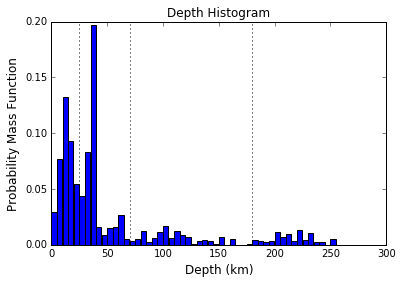

In [41]:
fig, ax = plt.subplots()
catalogue_temp = deepcopy(declustered2)
catalogue_temp.purge_catalogue((catalogue_temp.data['depth'] > 0) & (catalogue_temp.data['magnitude'] > 5.5))
plot_depth_histogram(catalogue_temp, 5, normalisation=True, ax=ax)
plt.xlim(LAYERS_DF.zmin.min(), LAYERS_DF.zmax.max())
[plt.axvline(x, color='black', linestyle=':') for x in np.sort(np.unique(LAYERS_DF[['zmin', 'zmax']].values))];
plt.savefig('Depth histogram (declustered mainshocks).png', dpi=300, bbox_inches='tight')

Try to assess the Poissoneity of the different candidate catalogues.

In [ ]:
catalogues = [catalogue, declustered, declustered2, declustered3]
names = ['raw', 'mainshocks', 'declustered mainshocks', 'declustered raw']
year_bin = 1

df_poisson = pd.DataFrame(columns=['best catalogue', 'layerid', 'min mag', 'start', 
                                   'events', 'years', 'activity rate', 
                                   'DT', 'BZ', "KSE'", 'KSU', 'all', 'w/o BZ'])
score = df_poisson.columns[-1]

for layer_id, completeness_table in zip(LAYERS_DF.index, completeness_tables):
    for cat, name in zip(catalogues, names):

        start_year = completeness_table[0][0]
        min_mag = completeness_table[0][1]
        df_catalogue = pd.DataFrame(cat.data)
        df_catalogue['t'] = cat.get_decimal_time()

        above_min = df_catalogue['magnitude'] >= min_mag
        in_years = df_catalogue['year'] >= start_year
        if layer_id == 'all':
            in_layer = np.full_like(in_years, True)
        else:
            in_layer = df_catalogue['layerid'] == layer_id

        t = df_catalogue[in_layer & in_years & above_min]['t']
        time_range = (int(start_year), np.ceil(catalogue.get_decimal_time().max()))
        duration =  time_range[1] - time_range[0]
        num_events = len(t)
        activity_rate = num_events/duration

        p_DT = poisson_test.dispersion(t, time_range) 
        p_BZ = poisson_test.brown_zhao(t, time_range)
        p_KSE2 = poisson_test.kolmogorov_smirnov(t, time_range, 'expon')
        p_KSU = poisson_test.kolmogorov_smirnov(t, time_range, 'uniform')
        p_DT_BZ_KSE2_KSU = poisson_test.combine_pvalues((p_DT, p_BZ, p_KSE2, p_KSU))[0]
        p_DT_KSE2_KSU = poisson_test.combine_pvalues((p_DT, p_KSE2, p_KSU))[0]

        result_list = [name, layer_id, min_mag, start_year, 
                       num_events, duration, activity_rate, 
                       p_DT, p_BZ, p_KSE2, p_KSU, 
                       p_DT_BZ_KSE2_KSU, p_DT_KSE2_KSU]
        result_series = pd.Series(result_list, index=df_poisson.columns)

        best_result = ((df_poisson['layerid'] == layer_id) &
                       (df_poisson['min mag'] == min_mag) &
                       (df_poisson['start'] == start_year))
        if not any(best_result.tolist()):
            df_poisson = df_poisson.append(result_series, ignore_index=True)
        else:
            if df_poisson[score][best_result].values[0] <= result_series[score]:
                print('layer %d > M%g since %d: Dropping %s (%.3g) in favour of %s (%.3g)' %
                      (layer_id, min_mag, start_year,
                       df_poisson['best catalogue'][best_result].values[0], 
                       df_poisson[score][best_result].values[0],
                       name, result_series[score], ))
                df_poisson.drop(np.where(best_result.values)[0], inplace=True)
                df_poisson = df_poisson.append(result_series, ignore_index=True)
            else:
                print('layer %d > M%g since %d: Keeping %s (%.3g) instead of %s (%.3g)' %
                      (layer_id, min_mag, start_year,
                       df_poisson['best catalogue'][best_result].values[0], 
                       df_poisson[score][best_result].values[0],
                       name, result_series[score], ))

df_poisson[['start', 'events', 'years']] = df_poisson[['start', 'events', 'years']].astype(int)
df_poisson.to_csv('MostPoissonianSubcatalogues.csv')
df_poisson

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/scipy/stats/stats.py:4957: RuntimeWarning: divide by zero encountered in log
  Xsq = -2 * np.sum(np.log(pvalues))


layer 1 > M4 since 2001: Dropping raw (0) in favour of mainshocks (0)
layer 1 > M4 since 2001: Dropping mainshocks (0) in favour of declustered mainshocks (0)
layer 1 > M4 since 2001: Dropping declustered mainshocks (0) in favour of declustered raw (0)
layer 2 > M4 since 1987: Dropping raw (0) in favour of mainshocks (2.53e-34)
layer 2 > M4 since 1987: Dropping mainshocks (2.53e-34) in favour of declustered mainshocks (2.3e-11)
layer 2 > M4 since 1987: Keeping declustered mainshocks (2.3e-11) instead of declustered raw (9.76e-39)
layer 3 > M4 since 1994: Dropping raw (1.88e-33) in favour of mainshocks (3.43e-28)
layer 3 > M4 since 1994: Dropping mainshocks (3.43e-28) in favour of declustered mainshocks (4.67e-26)
layer 3 > M4 since 1994: Keeping declustered mainshocks (4.67e-26) instead of declustered raw (3.07e-31)
layer 4 > M4 since 1988: Keeping raw (1.02e-36) instead of mainshocks (7.52e-53)
layer 4 > M4 since 1988: Dropping raw (1.02e-36) in favour of declustered mainshocks (1.67e

,best catalogue,layerid,min mag,start,events,years,activity rate,DT,BZ,KSE',KSU,all,w/o BZ
0,declustered raw,1,4.0,2001,2397,8,299.625000,1.373832e-47,0.0,9.037215e-14,0.000000e+00,0.0,0.000000e+00
1,declustered mainshocks,2,4.0,1987,3889,22,176.772727,1.428331e-10,0.0,3.691095e-02,8.653832e-03,0.0,2.297286e-11
2,declustered mainshocks,3,4.0,1994,1100,15,73.333333,2.439161e-18,0.0,6.914306e-02,1.232006e-10,0.0,4.670721e-26
3,declustered mainshocks,4,4.0,1988,259,21,12.333333,6.259083e-20,0.0,1.620223e-03,7.114779e-08,0.0,1.673487e-26


Now it's time to recompute smoothed-gridded seismicity. This is computationally intensive - on an Intel Core i7-4600U CPU @ 2.10GHz × 4 it takes an hour per layer, 8 hours in total.

To reproduce (nearly) the smoothed seismicity model of Nath & Thingbaijam (2012) use:
 - catalogue: "declustered"
 - completeness: "start_min"
 
An improved model would use a catalogue which is better declustered and which uses better estimates of completeness:
 - catalogue: "declustered3" (reassessed from original catalogue)
 - completeness: "completeness_tables" (obtained with the aid of Stepp and magnitude-density plots)
 
Note that this would result in just one smoothed seismicity model based on a time-varying magnitude of completeness, rather than two models with different completeness levels over different spans of time.

In [ ]:
# compute smoothed-gridded seismicity - INTENSIVE!
grid_step = 0.1
grid_setup = [min_lon - grid_step/2., max_lon + grid_step/2., grid_step, 
              min_lat - grid_step/2., max_lat + grid_step/2., grid_step, 0., 1000., 1000.]  
smoother = SmoothedSeismicity(grid_setup, use_3d=False, bvalue=1.0)

for ((zmin, zmax), layer), completeness_table \
        in zip(old_completeness_df.iterrows(), old_completeness_tables):
    for _, model in df_models.iterrows():
        catalogue_layer = deepcopy(declustered)
        layer_id = LAYERS_DF.index[LAYERS_DF.zmin == zmin].values
        in_layer = catalogue_layer.data['layerid'] == layer_id
        catalogue_layer.select_catalogue_events(in_layer)
        above_min = catalogue_layer.data['magnitude'] >= model['min mag']
        start_year = layer[(model['min mag'], 'start')]
        end_year = layer[(model['min mag'], 'end')]
        duration = end_year - start_year + 1
        print("Layer %d: %d events, %d with M >= %g or %.3g per year %d-%d" % (
            layer_id, len(above_min), sum(above_min), model['min mag'], 
            sum(above_min)/float(duration), start_year, end_year))
        
        large_csv = large_csv_template % (layer_id, model['min mag'])
        start_min = np.array([[start_year, model['min mag']]])
        config = {
            'Length_Limit': 3., 
            'BandWidth': model['corr dist'], 
            'increment': False}
        print('Smoothing with %g km kernel and completeness:\n%s' % 
              (config['BandWidth'], start_min))
        tick = time()
        output_data = smoother.run_analysis(
            catalogue_layer, config, start_min, 
            smoothing_kernel=IsotropicGaussian())
        print('Elapsed: %s' % pd.to_timedelta(time() - tick, unit='s'))
        print('Writing: %s\n' % large_csv)
        smoother.write_to_csv(large_csv)

Layer 1: 6283 events, 4187 with M >= 4.5 or 93 per year 1964-2008
Smoothing with 65 km kernel and completeness:
[[ 1964.      4.5]]


In [ ]:
# do some filtering and reprocessing of smoothed seismicity
# only want smoothed seismicity at points within bounding polygon of old model
# a shortcut towards this is to only keep points in old model
minimum = np.inf
maximum = 0
for min_mag in min_mags:
    for layer_id in LAYERS_DF.index:
        
        large_csv = large_csv_template % (layer_id, min_mag)
        small_csv = small_csv_template % (min_mag, layer_id)
        old_txt = old_txt_template % (layer_id, min_mag)
        new_txt = new_txt_template % (layer_id, min_mag)
        
        print('Reading: ' + old_txt)
        df_old = pd.read_csv(old_txt)
        df_old.rename(columns=COORDINATE_ALIASES, inplace=True)
        df_old.set_index(COORDINATES, inplace=True, verify_integrity=True)
        result_column = df_old.columns[0]

        # keep only points on the grid of the old model
        print('Reading: ' + large_csv)
        df_new = pd.read_csv(large_csv)
        df_new.rename(columns = COORDINATE_ALIASES, inplace=True)
        df_new.set_index(COORDINATES, inplace=True, verify_integrity=True)

        df_new = pd.merge(df_old, df_new, how='left', left_index=True, right_index=True)
        df_new.sort_index(inplace=True)
        
        # round the results
        minimum = min(minimum, df_new['Smoothed Rate'].min())
        maximum = max(maximum, df_new['Smoothed Rate'].max())
        df_new['Smoothed Rate'] = df_new['Smoothed Rate'].round(7)
        df_new['ratio'] = df_new['Smoothed Rate']/df_new[result_column]
        stats = df_new['ratio'].describe(percentiles=[0.05, 0.95])
        print('recomputed/original [%d points]: %.5f-%.0f; %s' % 
              (stats['count'], stats['min'], stats['max'], 
               '; '.join('%s: %.2g' % (key, stats[key]) 
                         for key in ['5%', 'mean', '95%'])))
        
        # get rid of uninteresting columns
        df_new.drop(['Depth', 'b-value'], axis=1, inplace=True)
        print('Writing: ' + small_csv)
        df_new.to_csv(small_csv)
        
        # also write new dataset in old format
        df_new.drop(result_column, axis=1, inplace=True)
        df_new.rename(columns={'Smoothed Rate': result_column}, inplace=True)
        df_new = df_new[result_column]
        print('Writing: %s\n' % new_txt)
        df_new.to_csv(new_txt, header=True, index=True)
                      
activity_limits = (stdval(minimum, 3, -0.5), stdval(maximum, 3, 0.5))
print('Smoothed Rate limits: %g - %g' % tuple(activity_limits))

In [ ]:
fig, axes = plt.subplots(len(LAYERS_DF.index), len(min_mags), figsize=(8, 12), 
                         sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0.3)
plot_smoothed_maps(small_csv_template, LAYERS_DF.index, min_mags, grid_step,
                   coordinate_limits, activity_limits, axes=axes)
fig.savefig('SmoothedRecalculated.png', dpi=300, bbox_inches='tight')
# plt.close(fig)

In [ ]:
fig, axes = plt.subplots(len(LAYERS_DF.index), 2*len(min_mags),
                         figsize=(11, 8.5), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 
                                     'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
plot_smoothed(old_txt_template, LAYERS_DF.index, min_mags, grid_step,
              coordinate_limits, activity_limits, axes[:, :2])
image = plot_smoothed(new_txt_template, LAYERS_DF.index, min_mags, grid_step,
                      coordinate_limits, activity_limits, axes[:, 2:])
fig.colorbar(image, ax=axes.ravel().tolist(), shrink=0.5,
             label=u'Events per year per %g° cell' % grid_step)

# add column group titles
x_left = axes[0, 0].get_position().xmax
x_right = axes[0, 2].get_position().xmax
y_bottom = axes[0, 0].get_position().ymax + 0.03
fig.text(x_left, y_bottom, 'Original',  ha='center', va='baseline')
fig.text(x_right, y_bottom, 'Recomputed',  ha='center', va='baseline')

fig.savefig('SmoothedComparisonNoMap.png', 
            dpi=300, bbox_inches='tight')

In [ ]:
c = 85  # km correlation distance
delta = 0.1  # grid spacing
span = 2.5  # test grid span
lon = 80  # degrees
lat = 20  # degrees
point = geo.Point(lon, lat)
lon_list = np.arange(lon - span, lon + span + delta/2, delta)
lat_list = np.arange(lat - span, lat + span + delta/2, delta)
lon_limits = (lon - span - delta/2, lon + span + delta/2)
lat_limits = (lat - span - delta/2, lat + span + delta/2)
lon_mesh, lat_mesh = np.meshgrid(lon_list, lat_list)
mesh = geo.RectangularMesh(lon_mesh, lat_mesh)
distances = point.distance_to_mesh(mesh)
i_mid = int(span/delta)
span_km = (distances[i_mid,:].max(), distances[:,i_mid].max())
print('Grid extents %g and %g km' % span_km)
print('Must be at least 3x correlation distance or %g km' % (3*c))
if all(np.array(span_km) > 3*c):
    print('OK!')
else:
    print('Problem!')
weights = np.exp(-(distances/c)**2) * (distances < 3*c)
print(u'For correlation distance %g km and grid spacing %g°' % (c, delta))
print('the unnormalized weights sum to %g.' % weights.sum())

In [ ]:
fig, ax = plt.subplots()
image = ax.imshow(distances, origin='lower', aspect='equal', 
                  interpolation='nearest',  extent=lon_limits + lat_limits)
ax.set_title('Test grid to compute smoothing normalization')
ax.set_xlabel(u'Longitude (°E)')
ax.set_ylabel(u'Latitude (°N)')
fig.colorbar(image);

In [ ]:
fig, ax = plt.subplots()
image = ax.imshow(weights, cmap='hot', origin='lower', aspect='equal', 
                  interpolation='nearest', extent=lon_limits + lat_limits)
ax.set_title('Weights on test grid')
ax.set_xlabel(u'Longitude (°E)')
ax.set_ylabel(u'Latitude (°N)')
fig.colorbar(image);